In [2]:
import sys, os, argparse, time
from datetime import datetime
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy import integrate
import skimage as ski
import skimage.io
import skimage.transform
import skimage.filters

np.seterr(all='raise')

def floatrange(start,end,inter):
    output = [start]
    while output[len(output)-1] < end:
        output.append(output[len(output)-1] + inter)
    return output

# Introduction

To model the edge detection system, we need to describe the dynamics of expression in each part of the gene circuit in every cell, and the diffusion of the signalling molecule AHL across the agar plate. We make the simplifying assumption that the gene circuit dynamics are happening much faster than the diffusion, so we only need a differential equation to solve the latter.

# Bacterial response functions

Here we describe the transcriptional output of the two promoters in the system - PompC and PLux-lambda. We denote these by $f_{light}$ and $f_{logic}$ respectively. We assume that these events are fast compared to diffusion and therefore that we can treat their action as functions of concentration only.

The experimental fit for $f_{light}$ goes approximately as a Michaelis-Menten equation with no-cooperativity (as you might expect!), where $\beta$ represents constants of Miller units used to normalize the curve.
$$
f_{light} = \frac{K}{K + L}(\beta_{max} - \beta_{min}) + \beta_{min} 
$$

$f_{logic}$ is a fair bit more empirical and complex. If $u_1$ and $u_2$ are the AHL and CI concentrations respectively,

$$
f_{logic}(u_1, u_2) = \frac{c_0 + c_1 f_{Lux}}{1+ c_o + c_1 f_{Lux} + c_2 f_{CI}^{1.5} + c_1 c_2 f_{Lux} f_{CI}^{1.5}}
$$

$f_{Lux}$ and $f_{CI}$ describe the binding of each transcription factor to its promoter respectively. Again, if you look at these expressions carefully you will see things reminiscent of Michaelis-Menten.

In [1]:
class Bacteria:
    '''
        This class is responsible for modelling the dynamics of the gene expression circuit.
        It holds all of the constants and the transfer functions that decide an output based
        on the current state of the cell.
    '''
    #Initiate constants
    f_light_K = 0.0017 # W/m^2 constant for f_light transfer function
    B_response_max = 298 # Miller units for maximum Beta-galactosidase activity
    B_response_min = 125 # Miller units for minimum Beta-galactosidase activity
    f_logic_c0 = 0.04
    f_logic_c1 = 0.05
    f_logic_c2 = 0.011
    f_logic_n = 1.5
    LuxRtot = 2000 # nM
    LuxR_dimer_K = 270000 # nM^3
    CI_dimer_K = 5 # nM

    def f_light(light_intensity):
        #Model ompC promoter
        B_response_range = Bacteria.B_response_max - Bacteria.B_response_min
        light_response = Bacteria.f_light_K / (Bacteria.f_light_K + light_intensity)
        return light_response * B_response_range + Bacteria.B_response_min
    
    def f_logic(AHL_conc, CI_conc):
        #Model lux-lambda promoter
        f_lux_term1 = Bacteria.LuxRtot + Bacteria.LuxR_dimer_K / (4 * AHL_conc ** 2)
        f_lux_c1 = (0.5 * (f_lux_term1 - np.sqrt(f_lux_term1 ** 2 - Bacteria.LuxRtot ** 2))) * Bacteria.f_logic_c1
        f_ci_c2 = (((CI_conc / 2) + (1 / (8 * Bacteria.CI_dimer_K)) * (1 - np.sqrt(1 + 8 * Bacteria.CI_dimer_K * CI_conc))) ** Bacteria.f_logic_n) * Bacteria.f_logic_c2
        f_logic_num = Bacteria.f_logic_c0 + f_lux_c1
        f_logic_denom = 1 + Bacteria.f_logic_c0 + f_lux_c1 + f_ci_c2 + f_lux_c1 * f_ci_c2
        return f_logic_num / f_logic_denom

# Encoding spatial information

We need to evaluate our system over the whole agar plate, so we make a class to store a coordinate system and the concentration of each chemical (LacZ (BGal), AHL, CI) at each point.

In [3]:
class Media:
    """
    This class stores spatial information about the media, i.e. the chemical concentrations
    at every point and their derivatives across space and time, required for update of the
    differential equations.
    """
    def __init__(self, radius_granularity, angle_granularity):
        # Store current state in 2D array of radius and angle
        self.AHL_history = np.zeros(shape=(radius_granularity, angle_granularity))
        self.CI_history = np.zeros(shape=(radius_granularity, angle_granularity))
        self.Bgal_history = np.zeros(shape=(radius_granularity, angle_granularity))
        self.dudt = np.zeros(shape=(radius_granularity, angle_granularity))
        self.dudr = np.zeros(shape=(radius_granularity, angle_granularity))
        self.du2dr2 = np.zeros(shape=(radius_granularity, angle_granularity))
        self.du2dtheta2 = np.zeros(shape=(radius_granularity,angle_granularity))
        self.light_term = np.zeros(shape=(radius_granularity,angle_granularity))
        self.decay_term = np.zeros(shape=(radius_granularity,angle_granularity))
    def get_cur_ahl_state(self):
        return self.AHL_history
    def get_cur_state(self):
        return (self.AHL_history,self.Bgal_history,self.CI_history)
    def get_cur_derivatives(self):
        return (self.dudt, self.dudr, self.du2dr2, self.du2dtheta2, self.light_term, self.decay_term)

# Running the code

We need an engine to execute the code. This will run the simulation when you tell it to do so, and make any plots that you ask for. Have a look at the available options in the `__init__` function, but don't worry about the rest.

In [9]:
class Simulation:
    """
    This class runs the simulations
    """
    def __init__(self, opath=datetime.now().strftime("%y%m%d-%H-%M-%S"),
                 plot=False, ginterval=10, end_time=24, dplot=False, tfs=False, maskpath=None,
                 maxlight=0.15, radius_granularity=100, angle_granularity=100):
        """
            opath - output path to save graphs
            plot - whether to plot Bgal and AHL concentrations
            ginterval - interval of timesteps with which to plot
            end_time - length of simulated time, in hours
            dplot - whether to plot the spatial derivatives of AHL conc
            tfs - whether to plot transfer functions
            maskpath - path for custom image mask
            maxlight - Maximum normalized light intensity
            radius_granularity - how many increments to divide the plate radius into
            angle_granularity - how many increments to divide 360 degrees into
        """
        
        #Initialize adjustable parameters according
        self.outputfolder = opath
        self.plots = plot
        self.graph_interval = ginterval
        self.max_time = end_time*60*60.0
        self.plot_derivatives = dplot
        self.plot_transfer_functions = tfs
        self.mask_path = maskpath
        self.max_light = maxlight
        self.radius_granularity = radius_granularity
        self.angle_granularity = angle_granularity

        #Granularity constants
        self.time_granularity = self.radius_granularity*2 # Time step twice as fine as space step
 
        
        #Setup initial conditions
        self.AHL_Diffusion_Coef = 1.67 * (10 ** (-7)) # cm^2/s
        self.plate_radius = 4.25 # cm
        self.k1 = 0.03/289 / 3600 / (self.AHL_Diffusion_Coef/self.plate_radius**2) # nM/hr converted to nM/dimensionless time
        self.k2 = 0.012 / 3600 / (self.AHL_Diffusion_Coef/self.plate_radius**2) # hr^-1 converted to 1/dimensionless time
        self.k3 = 0.8 # nM/Miller
        self.k4 = 289.0 # Miller units
        print("k1= ", self.k1)
        print("k2= ", self.k2)
        self.time_interval = self.max_time / self.time_granularity
        self.radius_interval = self.plate_radius / self.radius_granularity
        self.angle_interval = 2.0 * np.pi / self.angle_granularity

        # Generate sampling points
        # Sampling points start at 1/2 radius_interval
        self.radius_h = floatrange(self.radius_interval/2, self.plate_radius - self.radius_interval/2, self.radius_interval)
        self.angle_h = floatrange(0, 2 * np.pi - self.angle_interval, self.angle_interval)
        self.time_h = floatrange(self.time_interval, self.max_time, self.time_interval)
        #self.time_h = floatrange(self.time_interval, 24 * 3600, self.time_interval)

        #Initialize plate
        self.plate = Media(self.radius_granularity, self.angle_granularity)
        #Set light input
        self.light_mask = np.zeros(shape=(self.radius_granularity,self.angle_granularity))
        if self.mask_path == None:
            # If default mask, generate a spot of light half the radius of the plate
            for i in range(0,int(self.radius_granularity/2)):
                for j in range(0,self.angle_granularity):
                    self.light_mask[i,j] = self.max_light
        else:
            #If a greyscale image mask is specified, size image according to granularities and normalize to values between 0 and max light
            
            # Read image
            img = ski.io.imread(self.mask_path)
            
            # Scale image to resolution of plate radius
            (y, x) = img.shape
            scaling_factor = (((x/2)**2 + (y/2)**2)**(0.5))/(self.radius_granularity*0.95)
            img = ski.filters.gaussian(img, (1-1/scaling_factor)/2, preserve_range=True)

            # Sample image to populate light mask
            for i in range(0,int(self.radius_granularity)):
                for j in range(0,self.angle_granularity):
                    self.light_mask[i,j] = (self.interp(img, i, j, scaling_factor)/255.0)*self.max_light
            
            fig3 = plt.figure()
            rad = np.linspace(0,self.plate_radius,self.radius_granularity)
            azm = np.linspace(0,2 * np.pi,self.angle_granularity)
            th,r = np.meshgrid(azm,rad)
            z = self.light_mask
            ax = plt.subplot(1,1,1,projection="polar")
            ax.set_title("Mask")
            colors = plt.pcolormesh(th,r,z)
            plt.colorbar(colors)
            plt.grid()
            plt.show()

        self.total_time = 0

    def interp(self, img, i, j, scaling_factor):
        (y_max, x_max) = img.shape
        x_samp = (i * np.cos(j*2*np.pi/self.angle_granularity))*scaling_factor + x_max/2.0
        y_samp = y_max/2.0 - (i * np.sin(j*2*np.pi/self.angle_granularity))*scaling_factor
        #print(x_samp, y_samp)
        if (x_samp < 0 or x_samp > x_max - 1) or (y_samp < 0 or y_samp > y_max - 1):
            return 0
        else:
            if (x_samp == np.floor(x_samp)) or (y_samp == np.floor(y_samp)):
                i_samp = img[int(y_samp), int(x_samp)]
            else:
                x1 = int(np.floor(x_samp))
                x2 = int(np.ceil(x_samp))
                y1 = int(np.floor(y_samp))
                y2 = int(np.ceil(y_samp))
                a = (y1, x1)
                b = (y1, x2)
                c = (y2, x1)
                d = (y2, x2)
                #print (a, b, c, d, (y_samp, x_samp))
                i_samp = ((img[a]*(x2-x_samp) + img[b]*(x_samp-x1))*(y2-y_samp) + (img[c]*(x2-x_samp) + img[d]*(x_samp-x1))*(y_samp-y1))/((x2-x1)*(y2-y1))
            if i_samp < 0:
                print(i_samp)
                print(a,b,c,d)
            return i_samp

    def run(self):
        count = 0
        if self.plot_transfer_functions:
            self.plot_tfs()
            

        print("Simulating to: " + str(max(self.time_h)/60) + " minutes")
        if self.plots:
            print("Plotting every: " + str(self.graph_interval) + " timepoints")
        else:
            print("No plots being made")
        print("Each time step: " + str(self.time_interval/60) + " minutes")
        print("Dimensionless radius interval: ", self.dedimR(self.radius_interval))
        print("Dimensionless time interval: ", self.dedimT(self.time_interval))
        print("Theta interval: ", self.angle_interval)
        
        for t in self.time_h:
            #print(t)
            start = time.time()
            self.Step(t)
            count += 1
            if count % self.graph_interval == 0 and self.plots :
                self.make_plots(t);
            end = time.time()
            #print("Last step took " + str(end-start) + " seconds", end="\r")
        print(self.total_time)
        cur_state = self.plate.get_cur_state()
        print("Maximum Bgal concentration (Miller): ", cur_state[1].max())
        print("Maximum AHL concentration (nM): ", cur_state[0].max())

    def plot_tfs(self):
        # Plot transfer functions if flag is true
        light = floatrange(0, 0.1, 0.0001)
        f_light = [Bacteria.f_light(l) for l in light]
        tf_1 = plt.figure()
        ax1 = tf_1.add_subplot(1,1,1)
        ax1.set_title("f_light")
        ax1.set_xlabel("Light Intensity(W/m2)")
        ax1.set_ylabel("Miller Units")
        ax1.plot(light, f_light)
        
        ahl = np.geomspace(0.1, 250, 200)
        ci = np.linspace(120, 350, 100)
        ahlv, civ = np.meshgrid(ahl, ci)
        # Note that CI concentration for y-axis is defined in Millers (i.e. output of f_light)
        f_logic = Bacteria.f_logic(ahlv, civ*self.k3)
        tf_2 = plt.figure()
        ax2 = tf_2.add_subplot(1,1,1)
        ax2.set_title("f_logic")
        ax2.set_xscale("log")
        ax2.set_xlabel("AHL Concentration (nM)")
        ax2.set_ylabel("CI Concentration (Miller Units)")
        plt.contourf(ahlv, civ, f_logic, 30, cmap="jet", vmin=0, vmax=0.35)
        plt.colorbar()
        plt.show()
        
    def make_plots(self,t):
        #Plot Bgal and AHL
        maxzeros = int(np.log10(max(self.time_h))) + 1
        cur_state = self.plate.get_cur_state()
        fig = plt.figure()
        fig.suptitle(str(int(t/60)) + " min")
        #ax = Axes3D(fig)
        rad = np.linspace(0,self.plate_radius,self.radius_granularity)
        azm = np.linspace(0,2 * np.pi,self.angle_granularity)
        th,r = np.meshgrid(azm,rad)
        z = cur_state[1]
        ax = plt.subplot(1,2,1,projection="polar")
        ax.set_title("Bgal")
        colors = plt.pcolormesh(th,r,z)
        plt.colorbar(colors)
        plt.grid()
        z = cur_state[0]
        ax = plt.subplot(1,2,2,projection="polar")
        ax.set_title("AHL")
        colors = plt.pcolormesh(th,r,z)
        plt.colorbar(colors)
        plt.grid()
        #plt.show()
        if not os.path.isdir(self.outputfolder):
            os.mkdir(self.outputfolder)
        plt.savefig( os.path.join(self.outputfolder,str(int(t)).zfill(maxzeros) + "_" +
            str(self.time_granularity)+".png"))
        plt.close(fig)

        #Plot derivatives
        if self.plot_derivatives:
            fig2 = plt.figure(figsize=(8,6))
            fig2.suptitle(str(int(t/60)) + " min")
            derivs = self.plate.get_cur_derivatives()
            #ax = Axes3D(fig)
            rad = np.linspace(0,self.plate_radius,self.radius_granularity)
            azm = np.linspace(0,2 * np.pi,self.angle_granularity)
            th,r = np.meshgrid(azm,rad)
            z = derivs[0]
            ax = plt.subplot(2,3,1,projection="polar")
            ax.set_title("dudt")
            colors = plt.pcolormesh(th,r,z)
            plt.colorbar(colors)
            plt.grid()
            z = derivs[1]
            ax = plt.subplot(2,3,2,projection="polar")
            ax.set_title("1/r*dudr")
            colors = plt.pcolormesh(th,r,z)
            plt.colorbar(colors)
            plt.grid()
            z = derivs[2]
            ax = plt.subplot(2,3,3,projection="polar")
            ax.set_title("du2dr2")
            colors = plt.pcolormesh(th,r,z)
            plt.colorbar(colors)
            plt.grid()
            z = derivs[3]
            ax = plt.subplot(2,3,4,projection="polar")
            ax.set_title("1/r^2*du2dtheta2")
            colors = plt.pcolormesh(th,r,z)
            plt.colorbar(colors)
            plt.grid()
            z = derivs[4]
            ax = plt.subplot(2,3,5,projection="polar")
            ax.set_title("light term")
            colors = plt.pcolormesh(th,r,z)
            plt.colorbar(colors)
            plt.grid()
            z = derivs[5]
            ax = plt.subplot(2,3,6,projection="polar")
            ax.set_title("decay term")
            colors = plt.pcolormesh(th,r,z)
            plt.colorbar(colors)
            plt.grid()
            plt.tight_layout()
            #plt.show()
            if not os.path.isdir(self.outputfolder):
                os.mkdir(self.outputfolder)
            plt.savefig( os.path.join(self.outputfolder,"derivs_" + str(int(t)).zfill(maxzeros) + "_" +
                str(self.time_granularity)+".png"))
            plt.close(fig2)

# Reaction - Diffusion Equation

We've described most of the things going on biochemically, and we now need to simulate the physical motion of the AHL molecules. Remember, AHL diffusion from dark to light is what allows the edge detector to work! This is probably the most mathematically advanced part of the simulation, and requires the bulk of the computational power as well.

With reference to our previously defined $f_{light}$ and $f_{logic}$, the whole system can be described by the following three equations, where $u_1$ is AHL, $u_2$ is CI, and $u_3$ is LacZ (BGal).

$$
\frac{\partial u_1}{\partial t} = D \nabla^2 u_1 + \kappa_1 f_{light} - \kappa_2 u_1 \\
u_2 = \kappa_3 f_{light} \\
u_3 = \kappa_4 f_{logic}(u_1, u_2)
$$

The last two equations are the functions we have discussed before, with constants multiplied to accurately describe the observed molecular output as a result of gene expression. Recall that both AHL and CI production are under the control of PompC, while LacZ production is under the control of Plux-lambda.

The first equation might be trickier to parse if you don't have a mathematical or physical background. This is known as the reaction-diffusion equation. It considers a system in space and time, assuming that a quantity (in this case AHL concentration) is being produced/degraded at a not-necessarily uniform rate across the space. It then describes the diffusion of this quantity along its gradients (in most cases ultimately resulting from the random motion of particles).

The term on the left, $\frac{\partial u_1}{\partial t}$, is the derivative of AHL with respect to time. We want to find this quantity by evaluating the terms on the right, so we can track the progression of molecules on the plate over time and see how the edges are marked as the bacteria express the gene circuit.

The first term on the right, $D\nabla^2u_1$, is the diffusion component of the reaction. This term says that, without any production of molecule, the AHL concentration at a particular point will decrease over time according to the sum of the second derivatives in each coordinate direction. You can imagine this as describing the local curvature of AHL concentration. If a point is in a valley, AHL will tend to come towards it. If it is in a peak, it will tend to flow away.

The second term on the right, $\kappa_1 f_{light}$ describes the expression of AHL at this point according to PompC. The third term $-\kappa_2 u_1$ describes its degradation, which is a function of the current concentration.

Unlike $f_{light}$ and $f_{logic}$, it is very difficult to find an analytical form to the reaction-diffusion equation (i.e. $u_1(x,t) = f(x,t)$). We therefore numerically approximate the progression using the following idea:

$$
\frac{\partial u_1}{\partial t} = \lim_{\delta t \to 0} \frac{ u_1(x, t+ \delta t) - u_1(x, t)}{\delta t} \\
u_1(x, t+\delta t) \approx u_1(x, t) + \frac{\partial u_1}{\partial t} \delta t
$$

This is called the forward-difference approximation. We also need to numerically approximate the term $D\nabla^2u_1$. We do this using the _central_-difference approximation, which involves looking both forward and backwards. This is more accurate, and we can do this over space because we have full information at each time point.

For first and second derivatives, the central difference formulae are as follows:

$$
\frac{du}{dx} \approx \frac{ u(x+\delta x) - u(x-\delta x)}{2\delta x}\\
\frac{d^2u}{dx^2} \approx \frac{ u(x+\delta x) - 2 u(x) + u(x-\delta x)}{\delta x^2}
$$

In 2D polar coordinates, $D\nabla^2u_1$ is given by:

$$
D\nabla^2u_1 = \frac{1}{r}\frac{\partial u_1}{\partial r} + \frac{\partial^2 u_1}{\partial r^2} + \frac{1}{r^2} \frac{\partial^2 u_1}{\partial \theta^2}
$$

If you're feeling brave, try to implement the numerical approximations to this system in the next code box (noted by YOUR CODE HERE). Otherwise, skip it and try to convince yourself that the working version in the one below matches what has just been described. Note that the AHL concentration over space is given by `cur_state` and that you will need to dedimensionalise any measures of radius and time using the given functions.

### Your version

In [ ]:
def dedimR(self, r):
    """
    Dedimensionalise radius
    """
    return r / self.plate_radius

def dedimT(self, t):
    """
    Dedimensionalise time
    """
    return t * self.AHL_Diffusion_Coef / (self.plate_radius ** 2)

def Step(self, t):
    """
    This function steps through time and updates the chemical concentrations based on the equations.
    """
    cur_AHL_state = self.plate.get_cur_ahl_state()
        
    new_AHL_state = np.zeros(shape=(self.radius_granularity,self.angle_granularity))
    new_CI_state = np.zeros(shape=(self.radius_granularity,self.angle_granularity))
    new_Bgal_state = np.zeros(shape=(self.radius_granularity,self.angle_granularity))
    for i in range(0,self.radius_granularity):
        for j in range(0,self.angle_granularity):
            ### YOUR CODE HERE:
            ## new_AHL_state[i,j] = ???
            new_CI_state[i,j] = self.k3 * Bacteria.f_light(self.light_mask[i,j])
            new_Bgal_state[i,j] = self.k4 * Bacteria.f_logic(new_AHL_state[i,j],new_CI_state[i,j])
    self.plate.AHL_history = new_AHL_state
    self.plate.CI_history = new_CI_state
    self.plate.Bgal_history = new_Bgal_state
    self.total_time += self.dedimT(self.time_interval)

def UpdateAHL_conc(self,cur_state,i,j):
    """
    Calculates the rate change over time of AHL according to the change over space at each time
    point (reaction-diffusion equation)
    """
    dudt = 0
    dudr = 0
    du2dr2 = 0
    du2dtheta2 = 0
    # Get the radius and angle (accounting for the fact that the plate is a circle)
    # forward and backwards radius and angle correspond to r+dr, r-dr, theta+dtheta, theta-dtheta respectively
    forwardradius, backwardradius, forwardangle, backwardangle = self.get_radius_angles(i, j)
    
    # Solve the spatial derivatives
    # Don't worry about the edge cases
    if i == 0:
        dudr = 0 # Flux across the pole cancels out at first order
        du2dr2 = np.around((2.0*cur_state[forwardradius,j] - 2.0 * cur_state[i,j]), decimals=5) / (self.dedimR(self.radius_interval) ** 2.0)
    elif i == (self.radius_granularity - 1):
        dudr = (cur_state[i,j] - cur_state[backwardradius,j]) / (2.0 * self.dedimR(self.radius_interval))
        du2dr2 = np.around((cur_state[backwardradius,j]-cur_state[i,j]), decimals=5) / (self.dedimR(self.radius_interval) ** 2.0)
    else:
        ### YOUR CODE HERE:
        ## dudr = ???
        ## du2dr2 = ???

    ### YOUR CODE HERE
    ## du2dtheta2 = ???

    # Update the time derivative according to the reaction-diffusion equation
    dudt += 1.0/self.dedimR(self.radius_h[i])*dudr + du2dr2 + 1.0/(self.dedimR(self.radius_h[i]) ** 2.0)*du2dtheta2 + (self.k1) * Bacteria.f_light(self.light_mask[i,j]) - (self.k2) * cur_state[i,j]

    self.plate.dudt[i,j] = dudt
    self.plate.dudr[i,j] = dudr * 1.0/self.dedimR(self.radius_h[i])
    self.plate.du2dr2[i,j] = du2dr2
    self.plate.du2dtheta2[i,j] = du2dtheta2 *1.0/(self.dedimR(self.radius_h[i]) ** 2.0)
    self.plate.light_term[i,j] = (self.k1) * Bacteria.f_light(self.light_mask[i,j])
    self.plate.decay_term[i,j] = - (self.k2) * cur_state[i,j]
    return dudt

def get_radius_angles(self, i, j):
    if i == 0:
        backwardradius = i
    else:
        backwardradius = i - 1
    if i == (self.radius_granularity - 1):
        forwardradius = i
    else:
        forwardradius = i + 1
    if j == 0:
        backwardangle = self.angle_granularity - 1
    else:
        backwardangle = j - 1
    if j == (self.angle_granularity - 1):
        forwardangle = 0
    else:
        forwardangle = j + 1
    return forwardradius, backwardradius, forwardangle, backwardangle

Simulation.dedimR = dedimR
Simulation.dedimT = dedimT
Simulation.Step = Step
Simulation.UpdateAHL_conc = UpdateAHL_conc
Simulation.get_radius_angles = get_radius_angles

### Working version

In [10]:
def dedimR(self, r):
    """
    Dedimensionalise radius
    """
    return r / self.plate_radius

def dedimT(self, t):
    """
    Dedimensionalise time
    """
    return t * self.AHL_Diffusion_Coef / (self.plate_radius ** 2)

def Step(self, t):
    """
    This function steps through time and updates the chemical concentrations based on the equations.
    """
    cur_AHL_state = self.plate.get_cur_ahl_state()
        
    new_AHL_state = np.zeros(shape=(self.radius_granularity,self.angle_granularity))
    new_CI_state = np.zeros(shape=(self.radius_granularity,self.angle_granularity))
    new_Bgal_state = np.zeros(shape=(self.radius_granularity,self.angle_granularity))
    for i in range(0,self.radius_granularity):
        for j in range(0,self.angle_granularity):
            new_AHL_state[i,j] = cur_AHL_state[i,j] + self.UpdateAHL_conc(cur_AHL_state,i,j) * self.dedimT(self.time_interval)
            new_CI_state[i,j] = self.k3 * Bacteria.f_light(self.light_mask[i,j])
            new_Bgal_state[i,j] = self.k4 * Bacteria.f_logic(new_AHL_state[i,j],new_CI_state[i,j])
    self.plate.AHL_history = new_AHL_state
    self.plate.CI_history = new_CI_state
    self.plate.Bgal_history = new_Bgal_state
    self.total_time += self.dedimT(self.time_interval)

def UpdateAHL_conc(self,cur_state,i,j):
    """
    Calculates the rate change over time of AHL according to the change over space at each time
    point (reaction-diffusion equation)
    """
    dudt = 0
    dudr = 0
    du2dr2 = 0
    du2dtheta2 = 0
    # Get the radius and angle (accounting for the fact that the plate is a circle)
    forwardradius, backwardradius, forwardangle, backwardangle = self.get_radius_angles(i, j)

    # Solve the spatial derivatives
    if i == 0:
        dudr = 0 # Flux across the pole cancels out at first order
        du2dr2 = np.around((2.0*cur_state[forwardradius,j] - 2.0 * cur_state[i,j]), decimals=5) / (self.dedimR(self.radius_interval) ** 2.0)
    elif i == (self.radius_granularity - 1):
        dudr = (cur_state[i,j] - cur_state[backwardradius,j]) / (2.0 * self.dedimR(self.radius_interval))
        du2dr2 = np.around((cur_state[backwardradius,j]-cur_state[i,j]), decimals=5) / (self.dedimR(self.radius_interval) ** 2.0)
    else:
        dudr = (cur_state[forwardradius,j] - cur_state[backwardradius,j]) / (2.0 * self.dedimR(self.radius_interval))
        du2dr2 = np.around((cur_state[forwardradius,j] - 2.0 * cur_state[i,j] + cur_state[backwardradius,j]), decimals=5) / (self.dedimR(self.radius_interval) ** 2.0)

    du2dtheta2 = np.around((cur_state[i,forwardangle] - 2.0 * cur_state[i,j] + cur_state[i,backwardangle]), decimals=3) / (self.angle_interval ** 2.0)
        
    du2dtheta2 = np.around(du2dtheta2, decimals=3)

    # Update the time derivative according to the reaction-diffusion equation
    dudt += 1.0/self.dedimR(self.radius_h[i])*dudr + du2dr2 + 1.0/(self.dedimR(self.radius_h[i]) ** 2.0)*du2dtheta2 + (self.k1) * Bacteria.f_light(self.light_mask[i,j]) - (self.k2) * cur_state[i,j]

    self.plate.dudt[i,j] = dudt
    self.plate.dudr[i,j] = dudr * 1.0/self.dedimR(self.radius_h[i])
    self.plate.du2dr2[i,j] = du2dr2
    self.plate.du2dtheta2[i,j] = du2dtheta2 *1.0/(self.dedimR(self.radius_h[i]) ** 2.0)
    self.plate.light_term[i,j] = (self.k1) * Bacteria.f_light(self.light_mask[i,j])
    self.plate.decay_term[i,j] = - (self.k2) * cur_state[i,j]
    return dudt

def get_radius_angles(self, i, j):
    if i == 0:
        backwardradius = i
    else:
        backwardradius = i - 1
    if i == (self.radius_granularity - 1):
        forwardradius = i
    else:
        forwardradius = i + 1
    if j == 0:
        backwardangle = self.angle_granularity - 1
    else:
        backwardangle = j - 1
    if j == (self.angle_granularity - 1):
        forwardangle = 0
    else:
        forwardangle = j + 1
    return forwardradius, backwardradius, forwardangle, backwardangle

Simulation.dedimR = dedimR
Simulation.dedimT = dedimT
Simulation.Step = Step
Simulation.UpdateAHL_conc = UpdateAHL_conc
Simulation.get_radius_angles = get_radius_angles

# Running the code

We initialise a simulation object, and then call its method `sim.run()`. Watch the magic unfold (and check your output folder!).

Remember that the following parameters are available for you to play around with:
            
            opath - output path to save graphs
            plot - whether to plot Bgal and AHL concentrations
            ginterval - interval of timesteps with which to plot
            end_time - length of simulated time, in hours
            dplot - whether to plot the spatial derivatives of AHL conc
            tfs - whether to plot transfer functions
            maskpath - path for custom image mask
            maxlight - Maximum normalized light intensity
            radius_granularity - how many increments to divide the plate radius into
            angle_granularity - how many increments to divide 360 degrees into

k1=  3.118762475049901
k2=  360.52894211576853


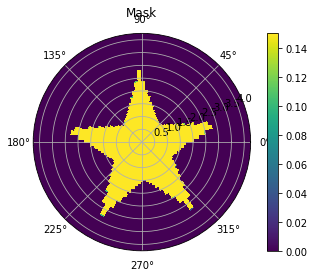

In [15]:
sim = Simulation(opath="test", maskpath="mask_star.tif", plot=True, dplot=True, tfs=True)

In [ ]:
sim.run()